# <span style="color:red"> Logistic Regression: Re-run with new train/test split</span>

* As the initial train/test split was performed on a random shuffle of all the chunks of text available there is the risk that the model is learning something of the style of the books themselves rather than the translator's. 
* The ideal solution would be to have the same text translated by each of the three translators. In the case of Haruki Murakami there is generally only one English language version of each of his novels available.  Fortunately one of his novels, 'Norwegian Wood' was first translated into English by Alfred Birnbaum for the Japanese market before being re-translated by Jay Rubin for the foreign market. I have the complete Rubin version and a few chapters of the Birnbaum version. Also the first chapter of 'A Wind-up Bird Chronicle' which was translated by Jay Rubin is also available as a short story in the collection 'The Elephant Vanishes', this time translated by Alfred Birnbaum.
* This notebook will therefore use these texts, which have the same Japanese source and two different translators, as the test set and train the model on the remaining texts. If the model is successful at predicting the translator We should therefore generate a model which is only differentiating on the translators style and not the theme or content of the books which is identical. 

**Test set 'Norwegian Wood' and 'Wind Up Bird Chronicle Chapter 1'- both are translated by Jay Rubin and again by Alfred Birnbaum**

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load the dataframe containing text chunks and related variables

In [50]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [51]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [52]:
df.shape

(5212, 142)

## Choose predictor features - dropping the words 'had' and 'he'

In [53]:
# prepare modelling
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

# select feature groups for modelling
predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm',
                'he_w', 'had_w']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

### Set Target and Predictor variables

In [54]:
X = df[predictor_cols]
y = df['trans_code']

## Version 1 - 3 translators in training set, 2 translators in test set

* Train Test Split with Test as both versions of Norwegian Wood and WUBC chapter 1
* Training set still includes Philip Gabriel Books

In [55]:
df['book_title'].unique()

array(['A Wild Sheep Chase', 'Kafka On The Shore',
       'Colorless Tsukuru Tazaki', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

### Check first chunk of Birnbaum version of Norwegian Wood
* Only a few later chapters of the Birnbaum version are available

In [56]:
df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Alfred Birnbaum')] \
            ['chunks'].iloc[0]

'The scene at dinner was pretty much the same as the evening before-same faces and talk and at\xadmosphere. Only the menu had changed. The lab\xadcoated man who had talked about stomach secretions under weightless conditions joined our table and told us about brain size in correlation to its abilities. He told us about the brain capacities of Napoleon and Bismarck while we ate something called soyburger steak. He pushed his plate aside and, pulling out a notepad, began to draw a diagram of the brain in ballpoint. "No, that’s not quite right," he’d say, then start over. When he finally finished the drawing to his satisfaction, he returned the notepad to a pocket of his lab coat and slipped the pen into his breast pocket. That made three ballpoint pens, a pencil, and a ruler in his breast pocket. "Winter’s great here, I tell you. You simply must come next winter," he said as he left, same as yesterday. "Is he a doctor or a patient?" was all I could think to ask Reiko.'

### As the chapter numbers are not available for the Rubin version. We need to find the equivalent chunk
* We can look for a chunk containing the word 'Napoleon' and translated by Rubin
* Then use that chunk as the start of the selectiong for his translation

In [57]:
def check_word(x):
    if 'Napoleon' in x:
        return x
    
df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Jay Rubin')] \
            ['chunks'].apply(lambda x: check_word(x)).dropna().iloc[0]

'"Tell me all about his, uh, you know, later." "We didn’t do any of that," said Naoko, reddening. "Really?" Reiko asked me. "Nothing?" "Nothing," I said. "Bo-o-o-ring!" she said with a bored look on her face. "True," I said, sipping my coffee. The scene in the dining hall was the same as the day before - the mood, the voices, the faces. Only the menu had changed. The balding man in white, who yesterday had been talking about the secretion of gastric juices under weightless conditions, joined the three of us at our table and talked for a long time about the correlation of brain size to intelligence. As we ate our soybean burgers, we heard all about the volume of Bismarck’s brain and Napoleon’s. He pushed his plate aside and used a ballpoint pen and notepaper to draw sketches of brains. He would start to draw, declare "No, that’s not quite it", and begin a new one. This happened several times.'

In [58]:
def check_word_flag(x):
    if 'Napoleon' in x:
        return True
    
df_temp = df.copy()
df_temp['napoleon'] = df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Jay Rubin')] \
            ['chunks'].apply(lambda x: check_word_flag(x))

In [59]:
df_temp[df_temp['napoleon'] == True]

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count,napoleon
3996,321,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914...","""Tell me all about his, uh, you know, later."" ...",Jay Rubin,Norwegian Wood,"("", Tell, me, all, about, his, ,, uh, ,, you, ...",18,168,690,212,118,24,135,9,1,903,19.933555,186.046512,764.119601,234.772979,130.675526,26.578073,149.501661,9.966777,0.6654,0.013,0.948,0.039,16.0,25.0,28.0,9.0,2.0,53.0,36.0,20.0,5.0,2.0,6.0,6.0,5.0,5.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,True


### set column to flag chunks to use as test dataset

In [60]:
df['test_flag'] = 0

In [61]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'Norwegian Wood' 
                    and row['translator'] == 'Jay Rubin' 
                    and row['book_chunk_no'] >= 321 
                    else row['test_flag'],
    axis=1
)

In [62]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'Norwegian Wood' 
                    and row['translator'] == 'Alfred Birnbaum' 
                    else row['test_flag'],
    axis=1
)

In [63]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'The Wind Up Bird Chronicle' 
                    and row['number'] == '1' 
                    and row['book_chunk_no'] < 60
                    else row['test_flag'],
    axis=1
)

### The first story of 'The Elephant Vanishes' short story collection is the same original text as 'The Wind-Up Bird Chronicle' chapter 1 but translated by Birnbaum

In [64]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'The Elephant Vanishes' 
                    and row['number'] == 1 
                    else row['test_flag'],
    axis=1
)

In [65]:
df['test_flag'].sum()

700

In [66]:
indices = list(df.index)

In [67]:
X_train = X[df['test_flag'] == 0]
y_train = y[df['test_flag'] == 0]
X_test = X[df['test_flag'] == 1]
y_test = y[df['test_flag'] == 1]
indices_train = [x for x, y in zip(indices, df['test_flag'] == 0) if y]
indices_test = [x for x, y in zip(indices, df['test_flag'] == 1) if y]

In [68]:
baseline_acc = y_test.value_counts(normalize=True).max()
baseline_acc

0.5042857142857143

In [69]:
X_test.tail()

,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,pron_count_norm,verb_count_norm,det_count_norm,adj_count_norm,noun_count_norm,adp_count_norm,cconj_count_norm,sconj_count_norm,adv_count_norm,aux_count_norm,part_count_norm,propn_count_norm,intj_count_norm,the_w,to_w,and_w,of_w,you_w,was_w,she_w,said_w,like_w,just_w,time_w,know_w,think_w,got_w,right_w,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,really_adv,back_adv,always_adv,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv
5248,19.269777,196.754564,758.620690,240.365112,117.647059,25.354970,161.257606,7.099391,25.354970,36.511156,30.425963,10.141988,31.440162,19.269777,5.070994,4.056795,15.212982,5.070994,3.042596,6.085193,2.028398,2,3,4,3,3,1,1,2,4,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,0,2,0,0,0
5249,32.289628,195.694716,746.575342,234.833659,110.567515,20.547945,163.405088,4.892368,40.117417,46.966732,13.698630,7.827789,14.677104,21.526419,2.935421,1.956947,20.547945,8.806262,6.849315,5.870841,2.935421,2,3,3,1,6,3,1,5,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,2,0,4,0,0,1,0,0,0,0,1,1,1,2,0,0,0,0
5250,21.671827,191.950464,769.865841,234.262126,127.966976,21.671827,157.894737,8.255934,27.863777,41.279670,18.575851,11.351909,24.767802,21.671827,7.223942,7.223942,16.511868,3.095975,2.063983,5.159959,1.031992,2,2,6,2,1,1,3,4,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1
5251,26.418787,196.673190,763.209393,239.726027,121.330724,22.504892,158.512720,3.913894,36.203523,47.945205,17.612524,8.806262,21.526419,8.806262,5.870841,2.935421,16.634051,8.806262,7.827789,10.763209,1.956947,6,9,5,1,7,0,4,3,3,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,1,2,0,0,0,1
5252,29.682702,206.755374,746.161720,242.579324,119.754350,16.376663,176.049130,5.117707,48.106448,40.941658,13.306039,7.164790,16.376663,19.447288,11.258956,2.047083,11.258956,16.376663,9.211873,9.211873,0.000000,6,8,7,4,5,2,2,4,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,2,0,0,0,1,0


In [70]:
y_test.tail()

5248    0
5249    0
5250    0
5251    0
5252    0
Name: trans_code, dtype: int64

In [328]:
# X_train = X_train.sample(frac=1, random_state=1)
# y_train = y_train.sample(frac=1, random_state=1)

### Standardise the predictor variables

In [71]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

###  Gridsearch Logistic Regression 

In [73]:
# gridsearch model parameters, score fitted model
params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
# lreg_gs_01 = lr.gridsearch(model, params, X_train, y_train)
lr.gridsearch(params, X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   32.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [74]:
# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_final_rerun'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

In [81]:
def gridsearch_score(model, X_train, y_train, X_test, y_test):
    # print the grid search results and store as a dictionary
    results_dict = {}
    results_dict['Best_Parameters'] = model.model_gs.best_params_
    results_dict['Best_CV_Score'] = model.model_gs.best_score_
    results_dict['Best_Train_Score'] = model.model_gs.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.model_gs.score(X_test, y_test)

    print('Best Parameters:')
    print(results_dict['Best_Parameters'])
    print('Best estimator mean cross validated training score:')
    print(results_dict['Best_CV_Score'])
    print('Best estimator score on the full training set:')
    print(results_dict['Best_Train_Score'])
    print('Best estimator score on the test set:')
    print(results_dict['Best_Test_Score'])
    predictions = model.model_gs.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [82]:
lreg_gs_01_results = gridsearch_score(lr, X_train, y_train, X_test, y_test)
lreg_gs_01_results

Best Parameters:
{'C': 0.1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6321033853648714
Best estimator score on the full training set:
0.6890514184397163
Best estimator score on the test set:
0.5457142857142857


{'Best_Parameters': {'C': 0.1, 'penalty': 'l2'},
 'Best_CV_Score': 0.6321033853648714,
 'Best_Train_Score': 0.6890514184397163,
 'Best_Test_Score': 0.5457142857142857,
 'conmat': array([[183,  78,  86],
        [ 98, 199,  56],
        [  0,   0,   0]])}

## Confusion Matrix

In [144]:
print(pd.DataFrame(lreg_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 183               78                 86
actual rubin                     98              199                 56
actual gabriel                    0                0                  0


## Classification Report

In [145]:
print(classification_report(y_test, lr.model_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       347
           1       0.75      0.49      0.59       353
           2       0.00      0.00      0.00         0

    accuracy                           0.47       700
   macro avg       0.47      0.31      0.37       700
weighted avg       0.70      0.47      0.56       700



/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot the most important features for predicting each translator

In [106]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lr.model_gs.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2'])
# remove n_ and _norm to make plots easier to read
df_coef.columns = [col.replace('_norm', '') for col in df_coef.columns ]
df_coef.columns = [col[2:] if col[:2] == 'n_' else col for col in df_coef.columns ]
# transpose to have columns as indices
df_coef = df_coef.T

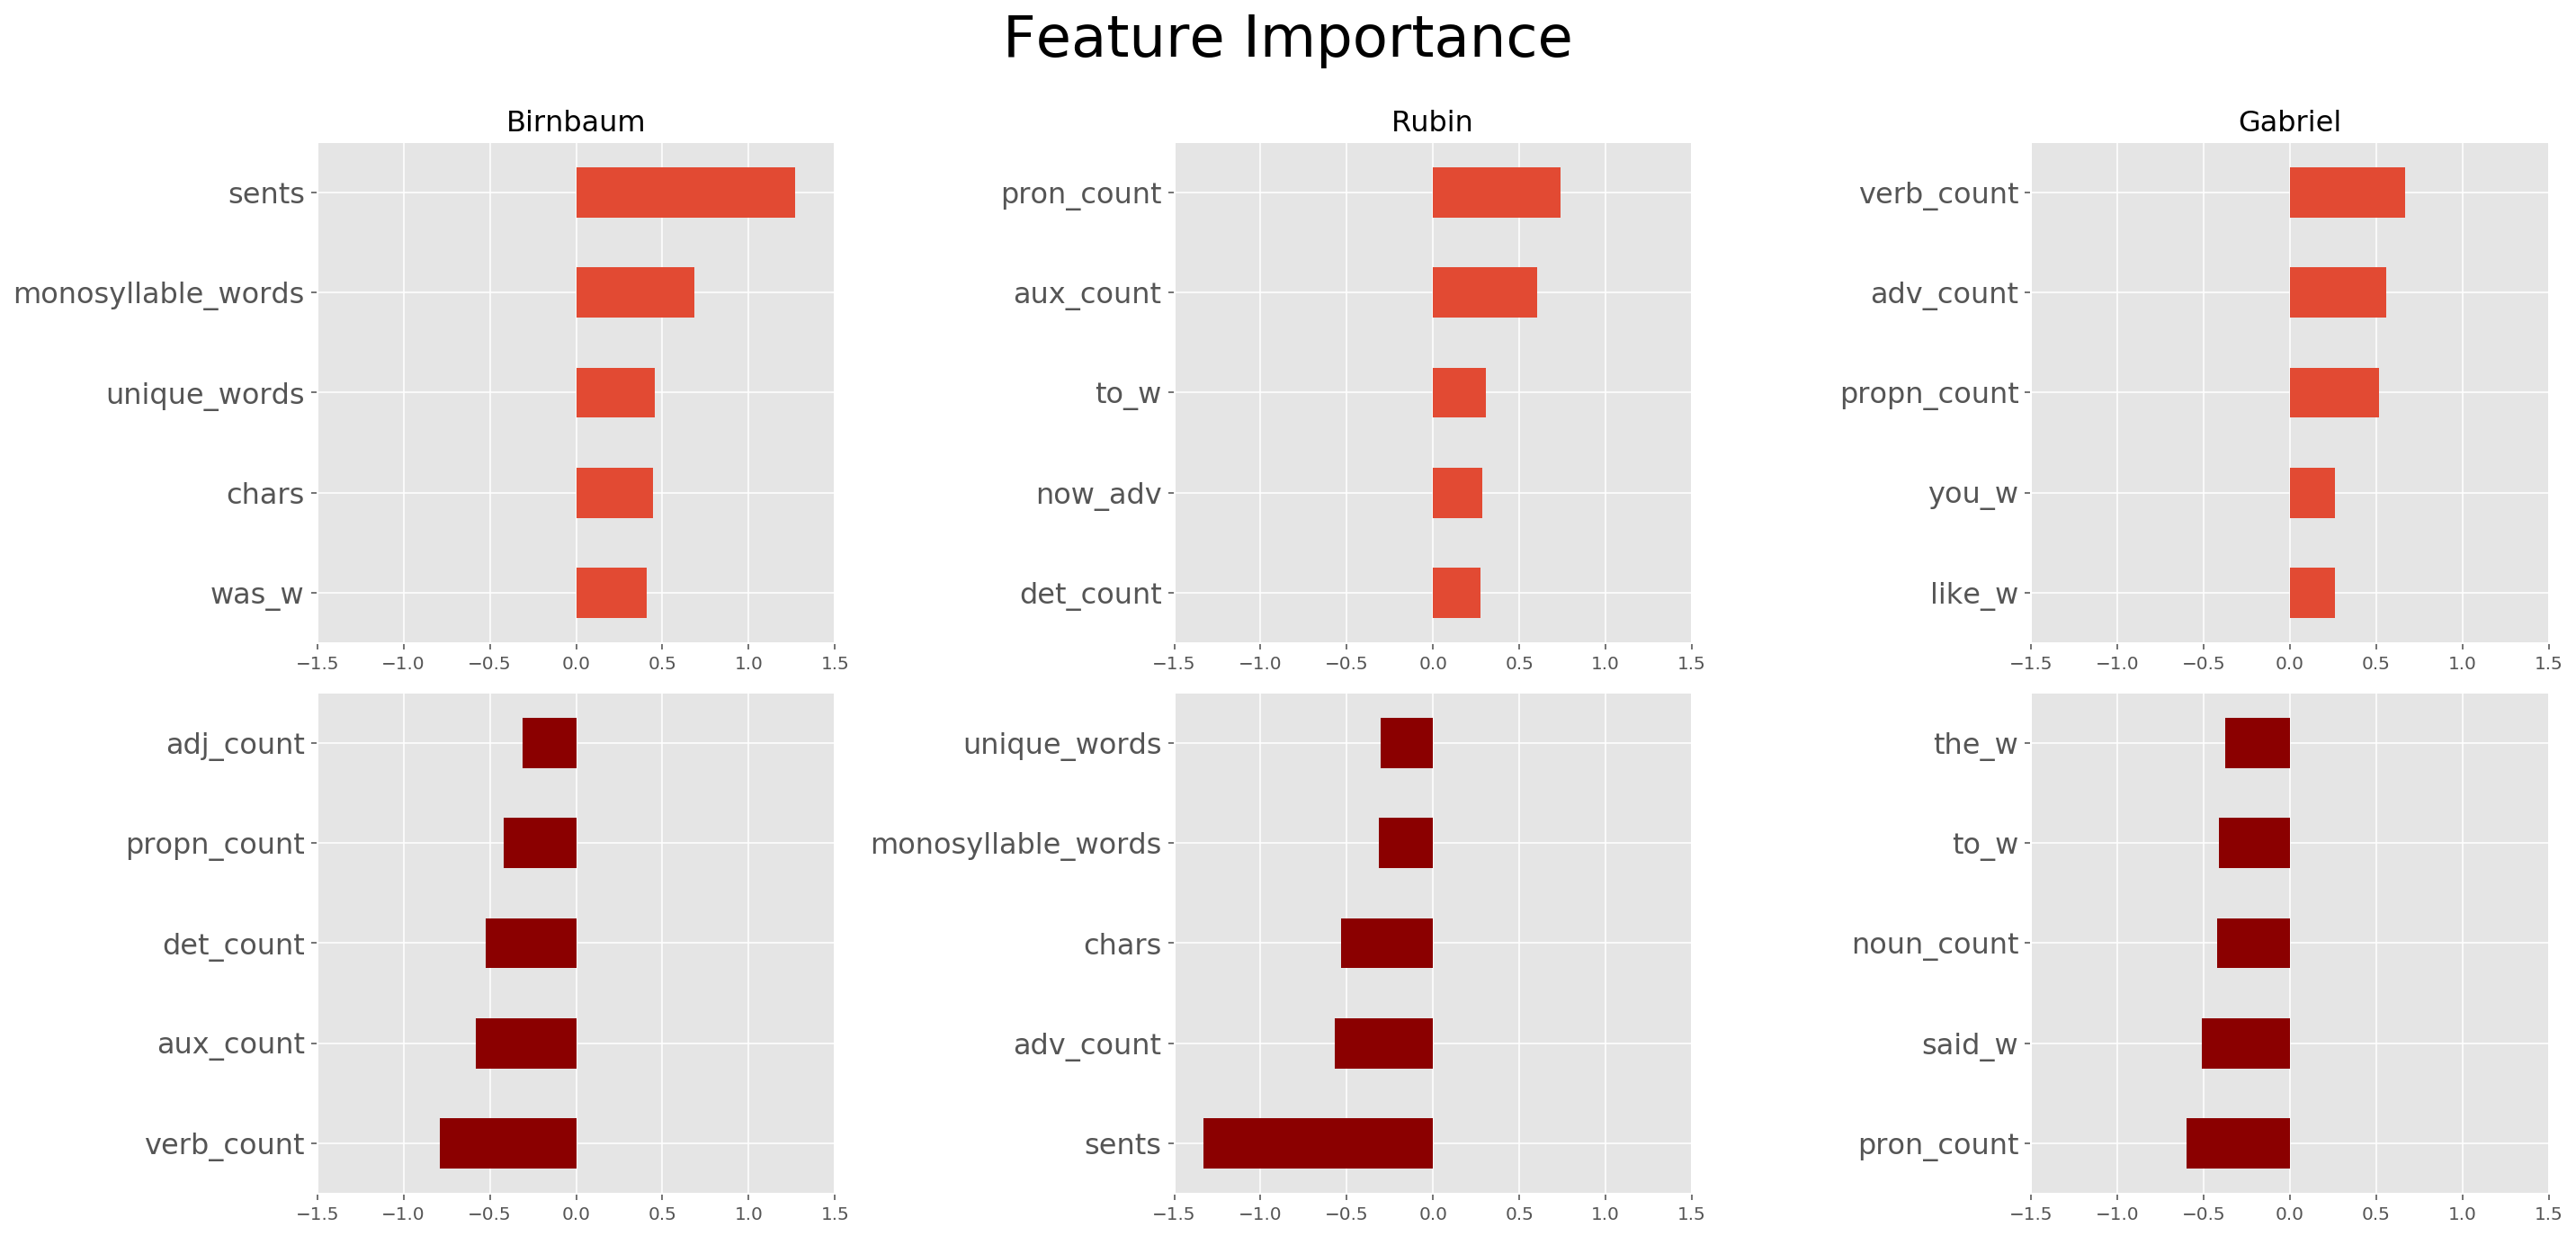

In [107]:
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(20, 10))
fig.suptitle('Feature Importance', fontsize=32)


for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    ax[0,i].set_xlim(-1.5, 1.5)
    ax[0,i].tick_params(axis='y', labelsize=16)


    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i], color='darkred')
    ax[1,i].set_xlim(-1.5, 1.5)
    ax[1,i].tick_params(axis='y', labelsize=16)

#     ax[1,i].xticks(fontsize=14)

ax[0,0].set_title('Birnbaum', fontsize=16)
ax[0,1].set_title('Rubin', fontsize=16)
ax[0,2].set_title('Gabriel', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
# plt.tight_layout()


# fig.suptitle('Largest Coefficient per Translator', fontsize=32, y=1.05)

plt.savefig('../../../../Documents/murakami/plots/top_lreg_coeffs_rerun_01.png')

plt.show()

## Review most confidently predicted texts per translator

In [84]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(lr.model_gs.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp', 'trans_2_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = indices_test
Y_pp.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index
0,0.068931,0.238973,0.692096,1878
1,0.271783,0.232344,0.495873,1879
2,0.492409,0.142716,0.364875,1880
3,0.718951,0.266874,0.014175,1881
4,0.394721,0.497260,0.108019,1882


In [229]:
# Y_pp_merged = Y_pp.join(df, how='left')

In [85]:
Y_pp_merged = Y_pp.merge(df, how='left', left_on='original_index', right_index=True)
# Y_pp_merged = Y_pp.merge(df, how='left', left_index=True, right_index=True)

In [86]:
len(Y_pp_merged)

700

In [87]:
Y_pp_merged.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,...,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count,test_flag
0,0.068931,0.238973,0.692096,1878,0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",I’M IN THEkitchen cooking spaghetti when the w...,Alfred Birnbaum,The Elephant Vanishes,"(I’M, IN, THEkitchen, cooking, spaghetti, when...",14,166,731,230,109,33,112,8,0,929,15.069968,178.686760,786.867600,247.578041,117.330463,35.522067,120.559742,8.611410,0.8903,0.037,0.862,0.102,16.0,32.0,24.0,3.0,2.0,38.0,34.0,18.0,4.0,1.0,15.0,5.0,2.0,10.0,...,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,0.271783,0.232344,0.495873,1879,1,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",And I pride myself on a near-perfect ear for v...,Alfred Birnbaum,The Elephant Vanishes,"(And, I, pride, myself, on, a, near, -, perfec...",25,206,814,262,123,30,161,9,0,1057,23.651845,194.891202,770.104068,247.871334,116.367077,28.382214,152.317881,8.514664,0.7800,0.040,0.872,0.088,27.0,36.0,25.0,14.0,7.0,53.0,35.0,22.0,7.0,2.0,13.0,11.0,6.0,1.0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,1
2,0.492409,0.142716,0.364875,1880,2,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...","“I hardly had any breakfast, so I was getting ...",Alfred Birnbaum,The Elephant Vanishes,"(“, I, hardly, had, any, breakfast, ,, so, I, ...",20,178,711,224,117,29,142,10,0,936,21.367521,190.170940,759.615385,239.316239,125.000000,30.982906,151.709402,10.683761,-0.8738,0.073,0.909,0.018,28.0,36.0,22.0,11.0,1.0,56.0,20.0,15.0,5.0,3.0,20.0,9.0,5.0,0.0,...,0,0,0,0,0,3,1,0,0,0,0,0,0,3,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.718951,0.266874,0.014175,1881,3,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",I stare blankly at the receiver in my hand and...,Alfred Birnbaum,The Elephant Vanishes,"(I, stare, blankly, at, the, receiver, in, my,...",13,197,803,254,129,30,149,7,0,1018,12.770138,193.516699,788.801572,249.508841,126.719057,29.469548,146.365422,6.876228,0.9094,0.014,0.909,0.077,22.0,33.0,27.0,6.0,3.0,26.0,45.0,28.0,7.0,4.0,12.0,7.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.394721,0.497260,0.108019,1882,4,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...","What the hell, I tell myself, what do I care a...",Alfred Birnbaum,The Elephant Vanishes,"(What, the, hell, ,, I, tell, myself, ,

In [88]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
555,0.906325,0.075669,0.018005,"They buy the sake, order the sushi, do the con...",Alfred Birnbaum,Norwegian Wood,151,9
255,0.889699,0.069218,0.041083,"Same as ever,"" I said, but then I recalled my ...",Jay Rubin,Norwegian Wood,482,2
210,0.885361,0.071775,0.042863,"I’ll give it to you - the TV, the thermos flas...",Jay Rubin,Norwegian Wood,437,2
79,0.883448,0.105965,0.010587,The yard of this house was very large. It had...,Jay Rubin,The Wind Up Bird Chronicle,27,1
463,0.882756,0.068277,0.048967,I’ve never done it under such controlled condi...,Alfred Birnbaum,Norwegian Wood,58,7


In [89]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
349,0.020338,0.966363,0.013299,"After saying goodbye to Midori, I bought a new...",Jay Rubin,Norwegian Wood,576,2
373,0.020789,0.958256,0.020956,"""No problem,"" I said. ""I have a big closet I ...",Jay Rubin,Norwegian Wood,600,2
121,0.034235,0.947123,0.018641,They said that I had snipped the clothes off m...,Jay Rubin,Norwegian Wood,348,2
107,0.057227,0.925386,0.017388,She asked me hundreds of questions - she was d...,Jay Rubin,Norwegian Wood,334,2
125,0.062161,0.919644,0.018195,"So he suggested that I leave first, go somewhe...",Jay Rubin,Norwegian Wood,352,2


In [90]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_2_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
520,0.055229,0.024142,0.920629,How come these simpletons don’t make an effort...,Alfred Birnbaum,Norwegian Wood,115,8
689,0.034747,0.061124,0.904129,"After all, you’d already made your decision be...",Alfred Birnbaum,Norwegian Wood,285,11
575,0.062731,0.048439,0.888830,"Midori burrowed her nose into my chest, her ha...",Alfred Birnbaum,Norwegian Wood,171,9
338,0.039494,0.090183,0.870323,"""How can you be such an idiot? Of course I wa...",Jay Rubin,Norwegian Wood,565,2
213,0.115853,0.025316,0.858831,They’re working their fingers to the bone. Or ...,Jay Rubin,Norwegian Wood,440,2


## Most confident for translator 0: 
* better now without 'A wild sheep chase' with the strange dialogue!

In [91]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

'They buy the sake, order the sushi, do the consoling and the crying, raise a fuss, divvy up the keepsakes. It’s easy. A picnic compared to visiting the hospital day in and day out, a real picnic. We were so exhausted, my sister and me, no tears would even come. Honest. It was enough to make others see us as cold. Still, we refused to cry, out of spite almost. Sure, we could have cried false tears, but no way were we about to put on a show for anyone. Everyone expecting us to cry only made us want to do the opposite. My sister and I are alike in that way, though otherwise we’re totally different." Midori’s bracelets rattled as she summoned a waiter to order another Tom Collins and pis\xadtachios. "Once everyone had gone home, we stayed up drinking sake until dawn, a whole big bottle of it. We bad-mouthed the lot of them, the funeral crowd. So-and-so was a real idiot, this guy a jerk. Mangy dogs, pigs, hypocrites, common crooks. The whole night through. We got it out of our systems and 

## Most confident for translator 1

In [94]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,3]

'After saying goodbye to Midori, I bought a newspaper at the station, but when I opened it on the train, I realized I had absolutely no desire to read a paper and in fact couldn’t understand what it said. All I could do was glare at the incomprehensible page of print and wonder what was going to happen to me from now on, and how the things around me would be changing. I felt as if the world was pulsating every now and then. I sighed deeply and closed my eyes. As regards what I had done that day, I felt not the slightest regret; I knew for certain that if I had to do it all over again, I would live this day in exactly the same way. I would hold Midori tight on the roof in the rain; I would get soaking wet with her; and I would let her fingers bring me to climax in her bed. I had no doubts about those things. I loved Midori, and I was happy that she had come back to me. The two of us could make it, that was certain. As Midori herself had said, she was a real, live girl with blood in her 

## Most confident for translator 2

In [97]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[0,3]

'How come these simpletons don’t make an effort? They don’t make an effort and they complain that things are unfair!" I shot Nagasawa a surprised look. "Correct me if I’m wrong, but from where I sit I sure get the impres\xadsion that people are grinding away like mad. Am I wrong?" "That’s not effort, that’s just labor," Nagasawa spat out. "Not the effort I’m talking about. The ef\xadfort I’m talking about is to go about things with will and purpose." "Like taking up Spanish once you’ve landed a job, when everybody else would just lie back?" "Precisely. I’m going to master Spanish by spring. To add to my English and German and French, plus passable Italian. Can you get this far without making an effort?" He took a drag on his cigarette and I thought of 103 Midori’s father. I don’t think he would even think of studying Spanish from TV. A difference between effort and labor? He’d probably been too busy to even consider that. Busy with work, busy bringing his daughter back from Fukushima.'

## Version 2 - 2 translators in training set, 2 translators in test set

* Train Test Split with Test as both versions of Norwegian Wood and WUBC chapter 1
* Training only includes Birnbaum and Rubin

In [113]:
df_2 = df[df.translator != 'Philip Gabriel']
df_2['book_title'].unique()

array(['A Wild Sheep Chase', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

### Set Target and Predictor variables

In [114]:
X = df_2[predictor_cols]
y = df_2['trans_code']

### Set column to flag chunks to use as test dataset

In [115]:
df_2['test_flag'] = 0

df_2['test_flag'] = df_2.apply(
    lambda row: 1 if row['book_title'] == 'Norwegian Wood' 
                    and row['translator'] == 'Jay Rubin' 
                    and row['book_chunk_no'] >= 321 
                    else row['test_flag'],
    axis=1
)

df_2['test_flag'] = df_2.apply(
    lambda row: 1 if row['book_title'] == 'Norwegian Wood' 
                    and row['translator'] == 'Alfred Birnbaum' 
                    else row['test_flag'],
    axis=1
)

df_2['test_flag'] = df_2.apply(
    lambda row: 1 if row['book_title'] == 'The Wind Up Bird Chronicle' 
                    and row['number'] == '1' 
                    and row['book_chunk_no'] < 60
                    else row['test_flag'],
    axis=1
)

df_2['test_flag'] = df_2.apply(
    lambda row: 1 if row['book_title'] == 'The Elephant Vanishes' 
                    and row['number'] == 1 
                    else row['test_flag'],
    axis=1
)

<ipython-input-115-7db1f285c1ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['test_flag'] = 0
<ipython-input-115-7db1f285c1ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['test_flag'] = df_2.apply(
<ipython-input-115-7db1f285c1ab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [116]:
df_2['test_flag'].sum()

700

In [117]:
indices = list(df_2.index)

In [118]:
X_train = X[df_2['test_flag'] == 0]
y_train = y[df_2['test_flag'] == 0]
X_test = X[df_2['test_flag'] == 1]
y_test = y[df_2['test_flag'] == 1]
indices_train = [x for x, y in zip(indices, df_2['test_flag'] == 0) if y]
indices_test = [x for x, y in zip(indices, df_2['test_flag'] == 1) if y]

In [119]:
baseline_acc = y_test.value_counts(normalize=True).max()
baseline_acc

0.5042857142857143

### Standardise the predictor variables

In [120]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

###  Gridsearch Logistic Regression 

In [121]:
# prepare modelling
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr_2 = Modelling(df_2, model)

In [122]:
# gridsearch model parameters, score fitted model
params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr_2.gridsearch(params, X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [124]:
# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_final_rerun_2'
out_full_path = out_path + out_name + '.pkl'
lr_2.save_model(out_full_path)

In [125]:
def gridsearch_score_2(model, X_train, y_train, X_test, y_test):
    # print the grid search results and store as a dictionary
    results_dict = {}
    results_dict['Best_Parameters'] = model.model_gs.best_params_
    results_dict['Best_CV_Score'] = model.model_gs.best_score_
    results_dict['Best_Train_Score'] = model.model_gs.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.model_gs.score(X_test, y_test)

    print('Best Parameters:')
    print(results_dict['Best_Parameters'])
    print('Best estimator mean cross validated training score:')
    print(results_dict['Best_CV_Score'])
    print('Best estimator score on the full training set:')
    print(results_dict['Best_Train_Score'])
    print('Best estimator score on the test set:')
    print(results_dict['Best_Test_Score'])
    predictions = model.model_gs.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1])

    return results_dict

In [126]:
lreg_gs_02_results = gridsearch_score_2(lr_2, X_train, y_train, X_test, y_test)
lreg_gs_02_results

Best Parameters:
{'C': 0.1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.7703703703703704
Best estimator score on the full training set:
0.8206119162640901
Best estimator score on the test set:
0.6671428571428571


{'Best_Parameters': {'C': 0.1, 'penalty': 'l1'},
 'Best_CV_Score': 0.7703703703703704,
 'Best_Train_Score': 0.8206119162640901,
 'Best_Test_Score': 0.6671428571428571,
 'conmat': array([[232, 115],
        [118, 235]])}

## Confusion Matrix

In [146]:
print(pd.DataFrame(lreg_gs_02_results['conmat'], index=['actual birnbaum', 'actual rubin'],
                             columns=['predicted birnbaum', 'predicted rubin']))

                 predicted birnbaum  predicted rubin
actual birnbaum                 232              115
actual rubin                    118              235


## Classification Report

In [147]:
print(classification_report(y_test, lr_2.model_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       347
           1       0.67      0.67      0.67       353

    accuracy                           0.67       700
   macro avg       0.67      0.67      0.67       700
weighted avg       0.67      0.67      0.67       700



### Plot the most important features for predicting each translator

In [130]:
# collect the model coefficients in a dataframe
df_2_coef = pd.DataFrame(lr_2.model_gs.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0'])
# remove n_ and _norm to make plots easier to read
df_2_coef.columns = [col.replace('_norm', '') for col in df_2_coef.columns ]
df_2_coef.columns = [col[2:] if col[:2] == 'n_' else col for col in df_2_coef.columns ]
# transpose to have columns as indices
df_2_coef = df_2_coef.T

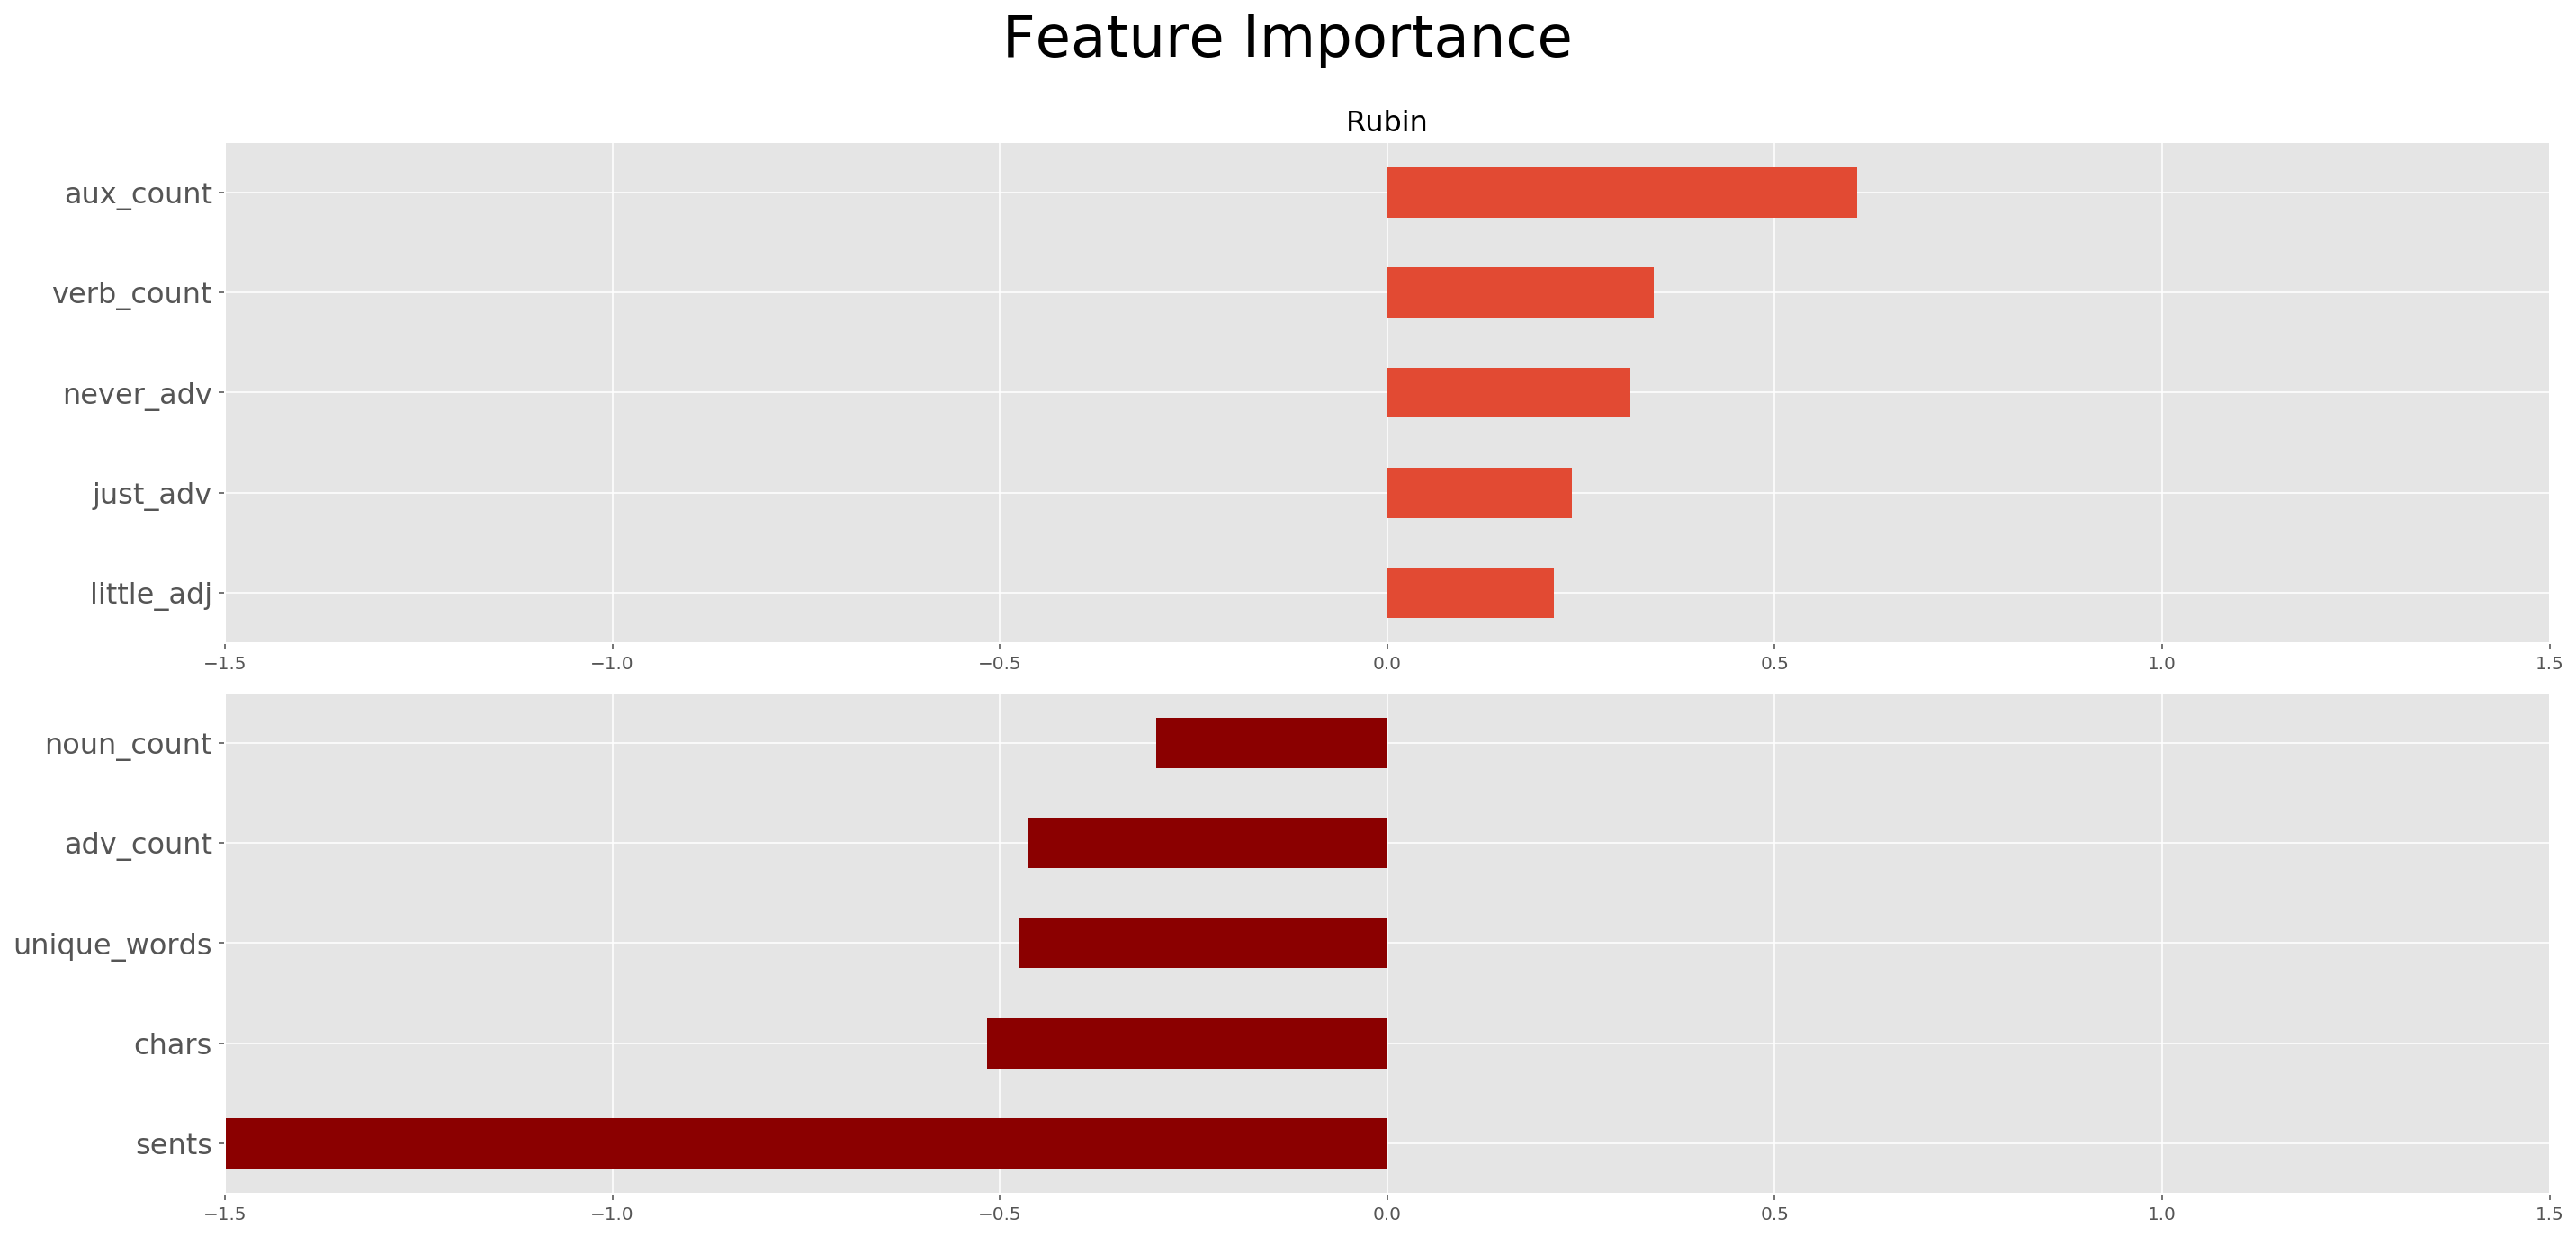

In [137]:
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, figsize=(20, 10))
fig.suptitle('Feature Importance', fontsize=32)


# df_2_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0], width=0.8)
df_2_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0])
ax[0].set_title(str(col), fontsize=18)
ax[0].set_xlim(-1.5, 1.5)
ax[0].tick_params(axis='y', labelsize=16)


df_2_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1], color='darkred')
ax[1].set_xlim(-1.5, 1.5)
ax[1].tick_params(axis='y', labelsize=16)

#     ax[1,i].xticks(fontsize=14)

ax[0].set_title('Rubin', fontsize=16)
# ax[0,1].set_title('Rubin', fontsize=16)
# ax[0,2].set_title('Gabriel', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
# plt.tight_layout()


# fig.suptitle('Largest Coefficient per Translator', fontsize=32, y=1.05)

plt.savefig('../../../../Documents/murakami/plots/top_lreg_coeffs_rerun_02.png')

plt.show()

## Review most confidently predicted texts per translator

In [135]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(lr_2.model_gs.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = indices_test
Y_pp.head()

,trans_0_pp,trans_1_pp,original_index
0,0.381548,0.618452,1878
1,0.626148,0.373852,1879
2,0.783229,0.216771,1880
3,0.816445,0.183555,1881
4,0.516272,0.483728,1882


In [138]:
Y_pp_merged = Y_pp.merge(df_2, how='left', left_on='original_index', right_index=True)

In [139]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(3)

,trans_0_pp,trans_1_pp,chunks,translator,book_title,book_chunk_no,number
65,0.998080,0.001920,“Or would you prefer me with something on? So...,Jay Rubin,The Wind Up Bird Chronicle,13,1
553,0.994236,0.005764,"""Too good for the likes of me."" * A buzzer ann...",Alfred Birnbaum,Norwegian Wood,149,9
612,0.990259,0.009741,No more of this want­ing to stay seventeen or ...,Alfred Birnbaum,Norwegian Wood,208,10


In [140]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(3)

,trans_0_pp,trans_1_pp,chunks,translator,book_title,book_chunk_no,number
181,0.000484,0.999516,"Back in the room, Midori told her father she h...",Jay Rubin,Norwegian Wood,408,2
350,0.001004,0.998996,It had been all I could do to suppress the int...,Jay Rubin,Norwegian Wood,577,2
385,0.002000,0.998000,"Oh, Reiko, it was so wonderful! Now it felt as...",Jay Rubin,Norwegian Wood,612,2


## Most confident for translator 0:  second most actually!

In [142]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[1,2]

'"Too good for the likes of me." * A buzzer announcing a telephone call broke into my sleep. There I’d been, dead to the world, plung\xading toward the inner reaches of dreamland. My head was swimming, my brain waterlogged. I didn’t know what was what. The clock read six-fifteen. A.M. or P.M.? Which day of the week? What date? The flag wasn’t atop the pole outside, so I figured it must be six-fifteen in the evening. So the flag\xadraising has some use after all. "Hey, Watanabe, you free?" Midori was asking. "What day is it?" "Friday." "Evening?" "Aren’t you the sharp one. What a thing to ask! Always an oddball, aren’t you? lt’s .. .let’s see ... six\xadeighteen P.M." Evening, eh? I must have fallen asleep while reading on my bed. Friday. No part-time job Friday 133 nights. "I guess I’m free. Where are you now?" "Ueno Station. Can you meet me in Shinjuku?" We fixed when and where to meet and then hung up. By the time I arrived at "Jazz and Booze" Dug, Midori was already seated at the en

In [143]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,2]

'Back in the room, Midori told her father she had some business to take care of and that I would be watching him while she was out. He seemed to have nothing to say to this. It might have meant nothing to him. He just lay there on his back, staring at the ceiling. If he hadn’t been blinking every once in a while, he could have passed for dead. His eyes were bloodshot as if he had been drinking, and each time he took a deep breath his nostrils flared a little. Other than that, he didn’t move a muscle, and made no effort to reply to Midori. I couldn’t begin to grasp what he might be thinking or feeling in the murky depths of his consciousness. After Midori left, I thought I might try speaking to her father, but I had no idea what to say to him or how to say it, so I just kept quiet. Before long, he closed his eyes and went to sleep. I sat on the stool by the head of the bed and studied the occasional twitching of his nose, hoping all the while that he wouldn’t die now. How strange it wou